# NLP Analysis of Sierra Club Press Releases

This notebook demonstrates an advanced Natural Language Processing (NLP) analysis of Sierra Club press releases. We'll cover various techniques including text preprocessing, word frequency analysis, named entity recognition, sentiment analysis, topic modeling, and more.

## Installation

Before we begin, let's install the necessary packages for this lab. Run the following cell to install the required libraries:


In [ ]:
%pip install nlp4ss
!python -m spacy download en_core_web_sm

## Setup and Data Loading


In [1]:
from hyfi import HyFI

if HyFI.is_colab():
    HyFI.mount_google_drive()
    project_root = "/content/drive/MyDrive/courses/nlp4ss"
else:
    project_root = "$HOME/workspace/courses/nlp4ss"

h = HyFI.initialize(
    project_name="nlp4ss",
    project_root=project_root,
    logging_level="INFO",
    verbose=True,
)

print("project_dir:", h.project.root_dir)
print("project_workspace_dir:", h.project.workspace_dir)

/Users/yj.lee/.venvs/nlp4ss/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:hyfi.utils.notebooks:Extension autotime not found. Install it first.
INFO:hyfi.joblib.joblib:initialized batcher with <hyfi.joblib.batcher.batcher.Batcher object at 0x16dcfcb90>
INFO:hyfi.main.config:HyFi project [nlp4ss] initialized


project_dir: /Users/yj.lee/workspace/courses/nlp4ss
project_workspace_dir: /Users/yj.lee/workspace/courses/nlp4ss/workspace


In [2]:
# Importing necessary libraries
import re

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pyLDAvis.gensim_models
import seaborn as sns
import spacy
from gensim import corpora
from gensim.models import CoherenceModel, LdaModel
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from wordcloud import WordCloud

# Download necessary NLTK data
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")
nltk.download("stopwords")

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Load the data
raw_data_file = h.project.workspace_dir / "data/raw/articles.jsonl"
rdata = h.load_dataset("json", data_files=raw_data_file.as_posix())
df = rdata["train"].to_pandas()

print("Data loaded. Shape:", df.shape)
print("\nSample of the data:")
print(df.head())

# Sample data
df = df.sample(500, random_state=42)

[nltk_data] Downloading package punkt to /Users/yj.lee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/yj.lee/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/yj.lee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yj.lee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Data loaded. Shape: (6354, 7)

Sample of the data:
                                               title       timestamp  \
0  Sierra Club Urges Commerce Department to Hold ...  April 15, 2024   
1  Sierra Club Statement on BOEM Financial Assura...  April 15, 2024   
2  We Energies Files Third Rate Increase in Three...  April 15, 2024   
3  MEDIA ADVISORY: Oregon Regulators to Hear Conc...  April 12, 2024   
4  Advisory: Special Meeting for County Commissio...  April 12, 2024   

                                                 url  \
0  https://www.sierraclub.org/press-releases/2024...   
1  https://www.sierraclub.org/press-releases/2024...   
2  https://www.sierraclub.org/press-releases/2024...   
3  https://www.sierraclub.org/press-releases/2024...   
4  https://www.sierraclub.org/press-releases/2024...   

                                            page_url  page  \
0  https://www.sierraclub.org/press-releases?_wra...     1   
1  https://www.sierraclub.org/press-releases?_wra...   

## Text Preprocessing

We'll now preprocess the text data. This includes lowercasing, removing special characters, tokenization, removing stopwords, and lemmatization. We'll also filter for only nouns and adjectives, which are typically the most informative for topic modeling.


In [3]:
# Custom stopwords list
custom_stopwords = set(stopwords.words("english"))
custom_stopwords.update(
    ["sierra", "club", "press", "release"]
)  # Add domain-specific stopwords


def preprocess_text(text):
    # Lowercase and remove special characters
    text = re.sub(r"[^a-zA-Z\s]", "", text.lower())

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords and keep only nouns and adjectives
    lemmatizer = WordNetLemmatizer()
    tokens = [
        lemmatizer.lemmatize(token)
        for token, pos in pos_tag(tokens)
        if pos.startswith("NN") or pos.startswith("JJ")
    ]

    return [token for token in tokens if token not in custom_stopwords]


# Apply preprocessing to all documents
df["processed_text"] = df["content"].apply(preprocess_text)
df["processed_string"] = df["processed_text"].apply(" ".join)

print("Preprocessing completed.")
print("\nSample of processed text:")
print(df["processed_text"].head())

Preprocessing completed.

Sample of processed text:
5775    [april, contact, emilypomiliosierracluborg, ba...
1840    [october, contact, shiloh, hernandez, earthjus...
4272    [contact, courtney, bourgoin, washington, dc, ...
80      [black, household, high, energy, burden, histo...
3133    [february, contact, gabby, gabbybrownsierraclu...
Name: processed_text, dtype: object


## Word Frequency Analysis

Let's analyze the most frequent words in our corpus. This can give us a quick overview of the main themes in the press releases.


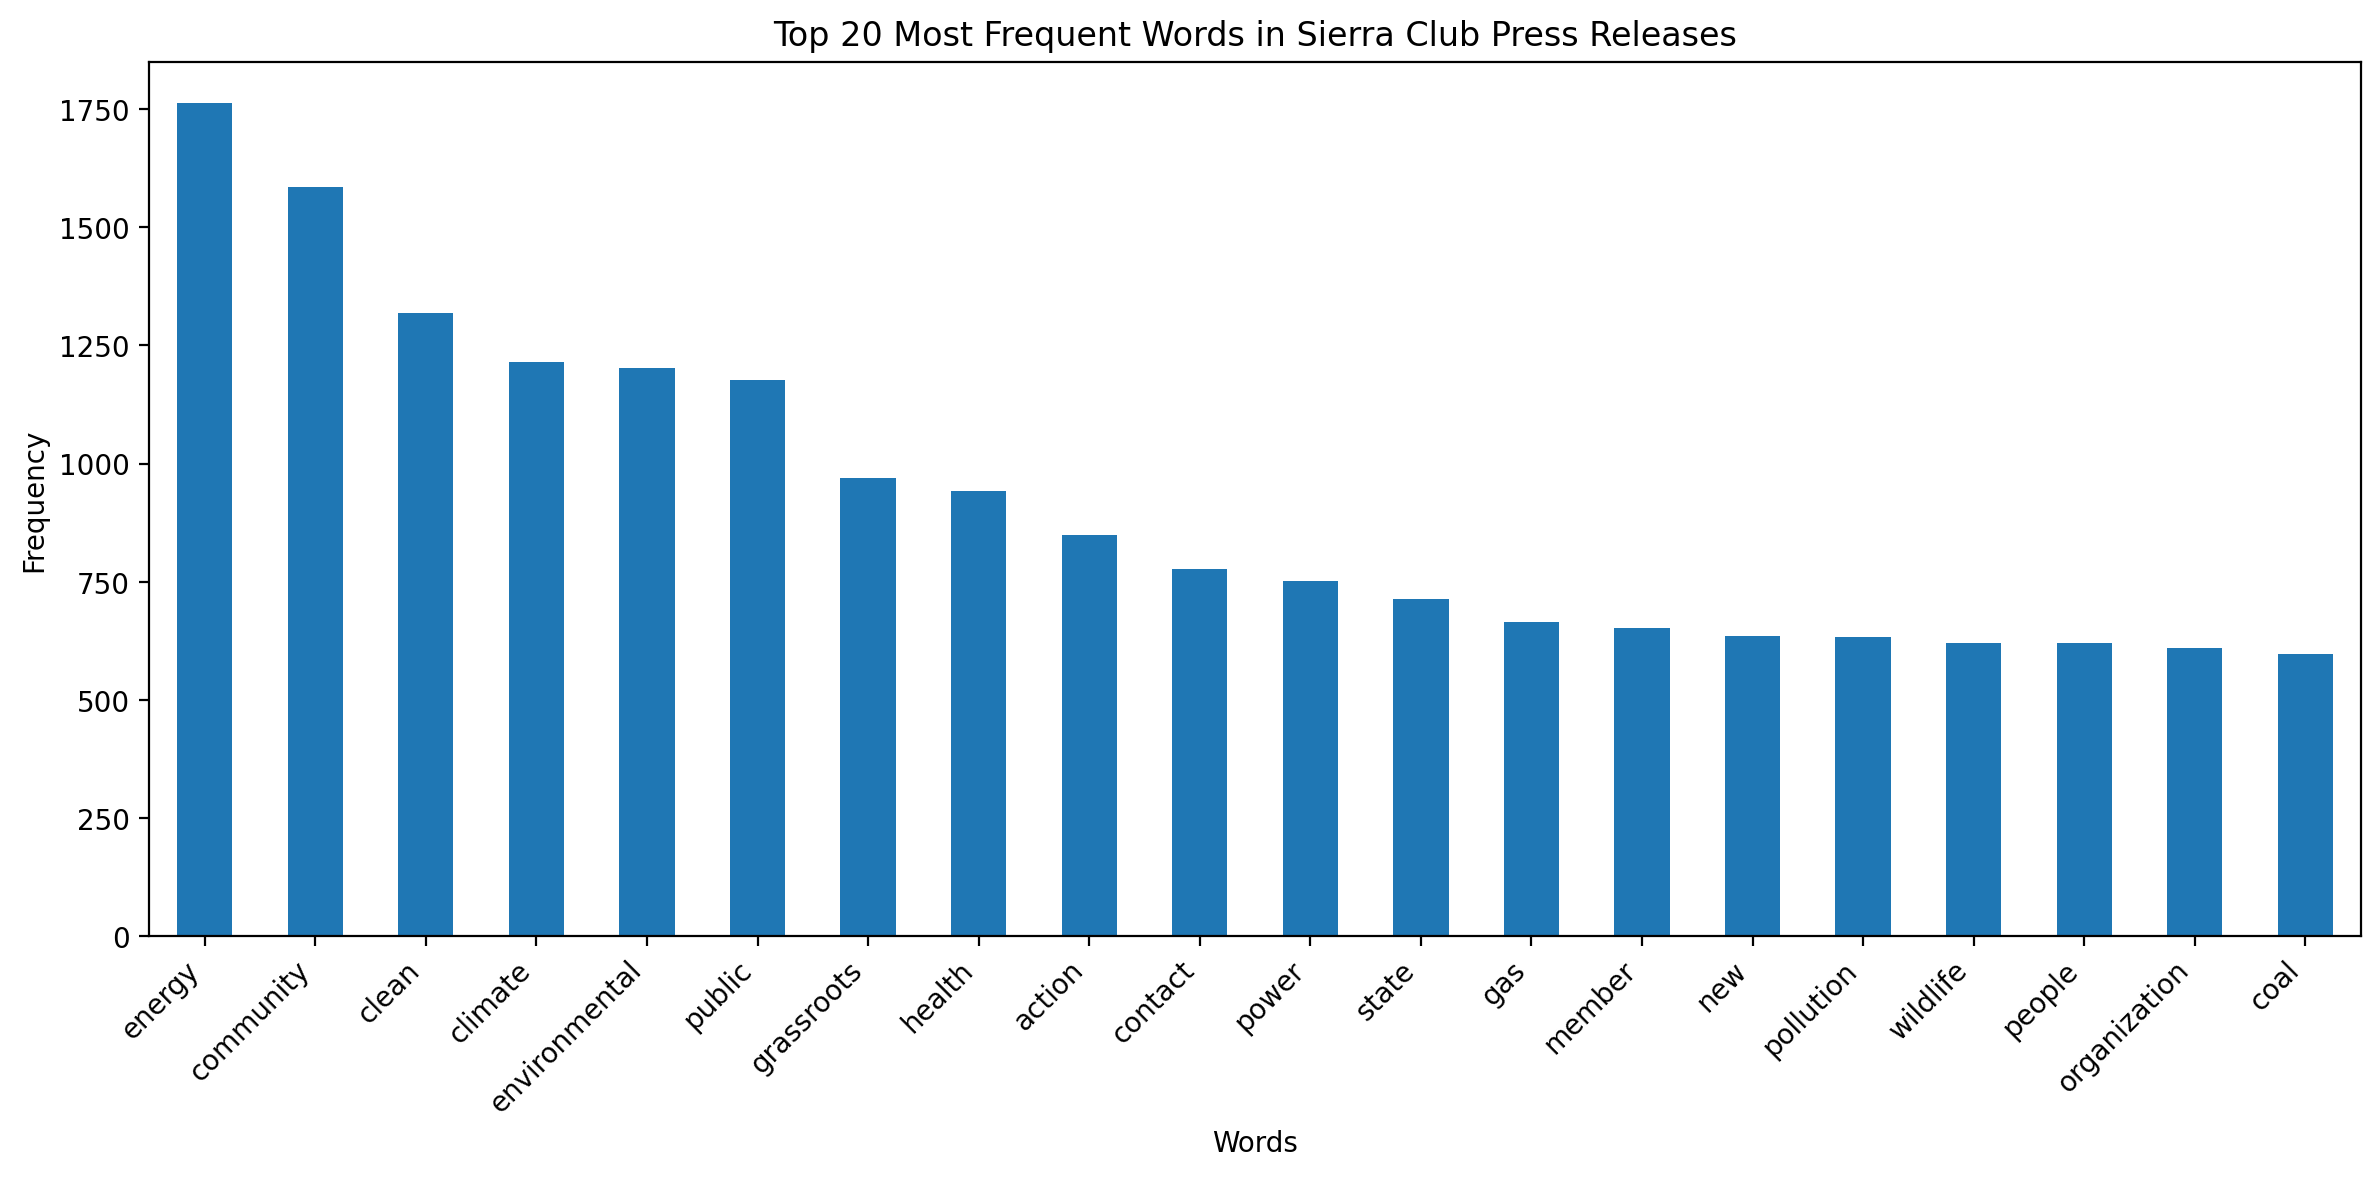

In [20]:
def plot_word_frequency(text, title, n=20):
    word_freq = pd.Series(" ".join(text).split()).value_counts()[:n]
    plt.figure(figsize=(12, 6))
    word_freq.plot(kind="bar")
    plt.title(title)
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


plot_word_frequency(
    df["processed_string"], "Top 20 Most Frequent Words in Sierra Club Press Releases"
)

## Named Entity Recognition

Named Entity Recognition (NER) can help us identify key entities (like people, organizations, or locations) mentioned in the press releases.


In [5]:
def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]


# Extract entities from a sample of articles
sample_size = min(100, len(df))
sample_entities = (
    df["content"].sample(n=sample_size, random_state=42).apply(extract_entities)
)
entity_df = pd.DataFrame(
    [entity for entities in sample_entities for entity in entities],
    columns=["Entity", "Label"],
)

print("Top 10 most common named entities:")
print(entity_df["Entity"].value_counts().head(10))

Top 10 most common named entities:
Entity
Sierra Club           236
EPA                    97
America                95
The Sierra Club is     76
California             55
Trump                  54
the Sierra Club        50
Today                  46
LNG                    45
millions               42
Name: count, dtype: int64


## Sentiment Analysis

Sentiment analysis can help us understand the overall tone of the press releases.


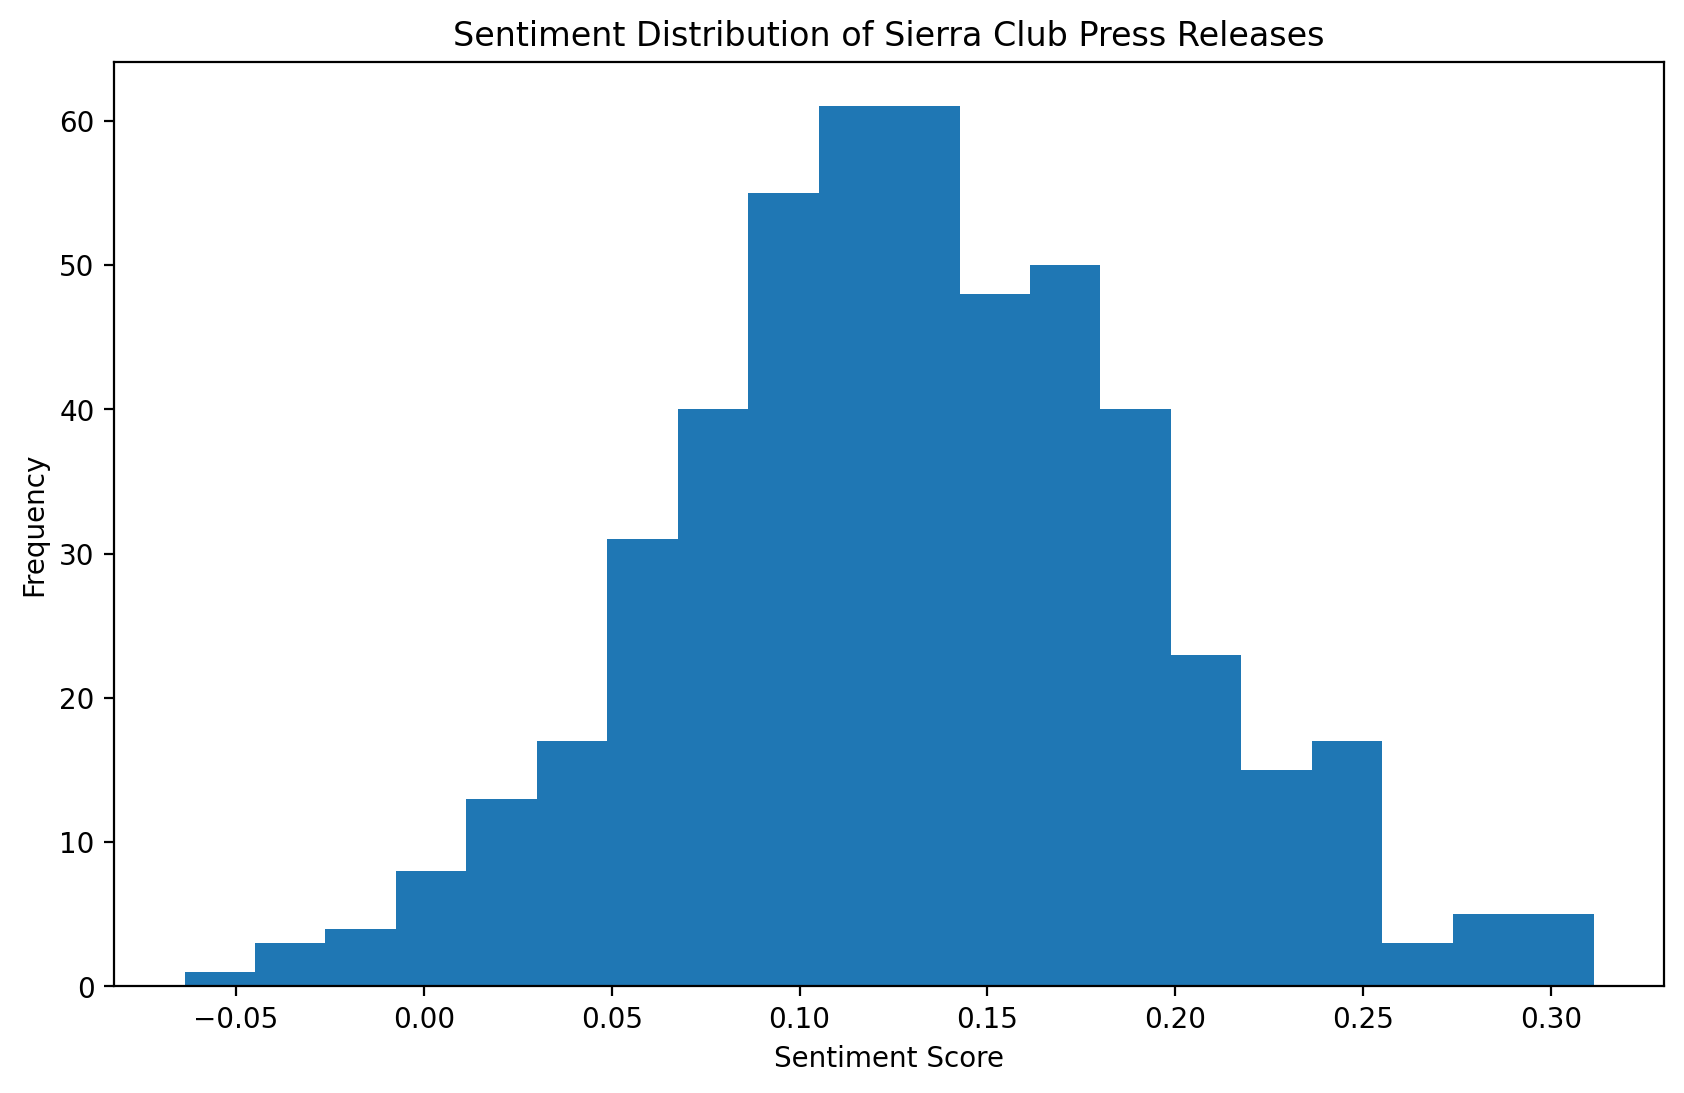

Average sentiment: 0.13


In [6]:
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity


df["sentiment"] = df["content"].apply(get_sentiment)

plt.figure(figsize=(10, 6))
plt.hist(df["sentiment"], bins=20)
plt.title("Sentiment Distribution of Sierra Club Press Releases")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()

print(f"Average sentiment: {df['sentiment'].mean():.2f}")

## TF-IDF Analysis

TF-IDF (Term Frequency-Inverse Document Frequency) can help us identify important terms in each document.


In [7]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df["processed_string"])

feature_names = tfidf_vectorizer.get_feature_names_out()
first_doc_vector = tfidf_matrix[0]
top_terms = sorted(
    zip(feature_names, first_doc_vector.toarray()[0]), key=lambda x: x[1], reverse=True
)[:10]

print("Top 10 terms in the first document (TF-IDF):")
for term, score in top_terms:
    print(f"{term}: {score:.4f}")

Top 10 terms in the first document (TF-IDF):
maryland: 0.5512
efficiency: 0.4094
program: 0.3417
energy: 0.2247
bill: 0.1988
legislation: 0.1901
service: 0.1784
state: 0.1305
governor: 0.1268
electricity: 0.1247


## Topic Modeling

We'll use Latent Dirichlet Allocation (LDA) for topic modeling. First, we'll determine the optimal number of topics.


In [ ]:
id2word = corpora.Dictionary(df["processed_text"])
corpus = [id2word.doc2bow(text) for text in df["processed_text"]]


def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=100,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha="auto",
            per_word_topics=True,
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(
            model=model, texts=texts, dictionary=dictionary, coherence="c_v"
        )
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values


model_list, coherence_values = compute_coherence_values(
    dictionary=id2word,
    corpus=corpus,
    texts=df["processed_text"],
    start=5,
    limit=40,
    step=5,
)

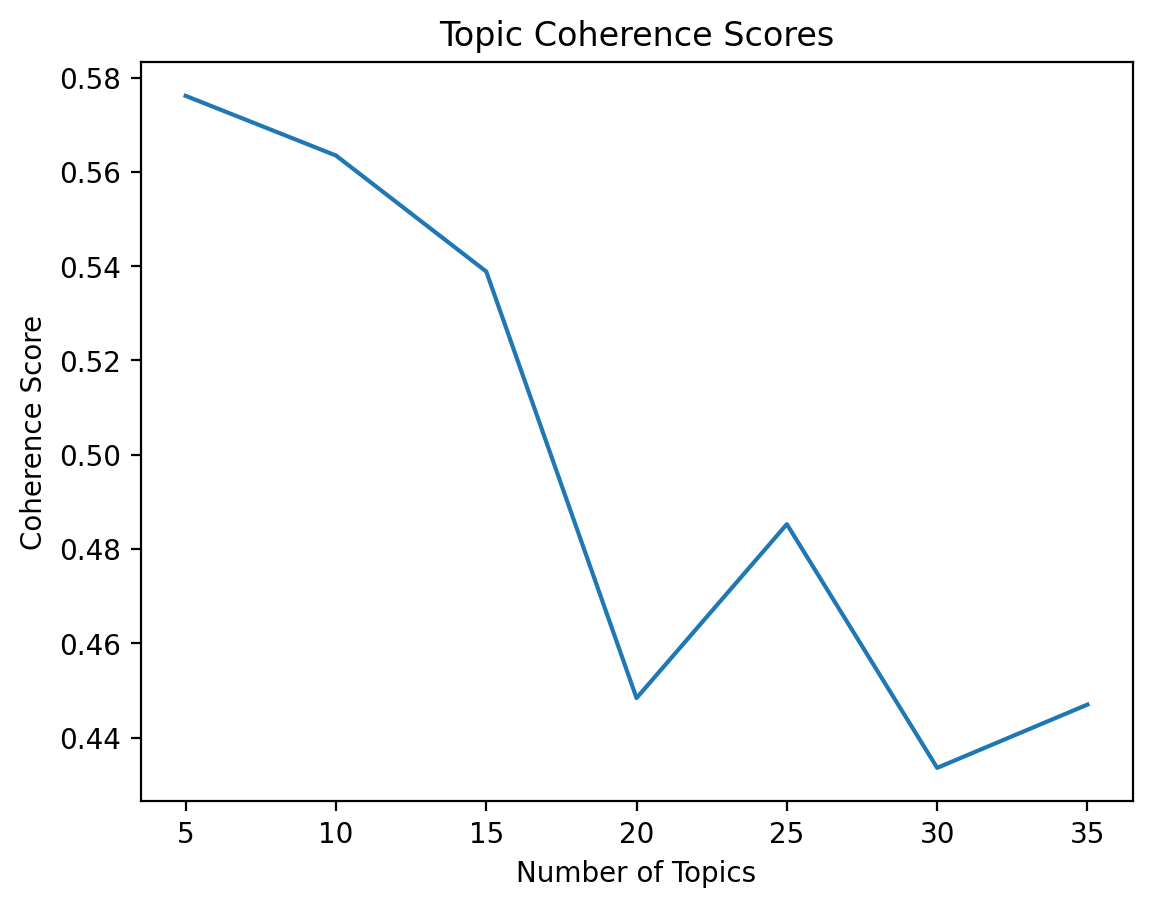

Optimal number of topics: 5


In [9]:
# Plot coherence scores
plt.plot(range(5, 40, 5), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Topic Coherence Scores")
plt.show()

# Find the optimal number of topics
optimal_num_topics = coherence_values.index(max(coherence_values)) * 5 + 5
print(f"Optimal number of topics: {optimal_num_topics}")

Now that we have the optimal number of topics, let's train our LDA model and examine the results.


In [ ]:
# Train LDA model with optimal number of topics
lda_model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=optimal_num_topics,
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha="auto",
    per_word_topics=True,
)

# Print topics
print("Top words for each topic:")
topics = lda_model.print_topics()
for idx, topic in topics:
    print(f"Topic {idx}: {topic}")

# Visualize topics
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(vis, "lda_visualization.html")
print("\nLDA visualization saved as 'lda_visualization.html'")

In [11]:
pyLDAvis.display(vis)

## Topic-Sentiment Analysis

Let's analyze the sentiment associated with each topic.


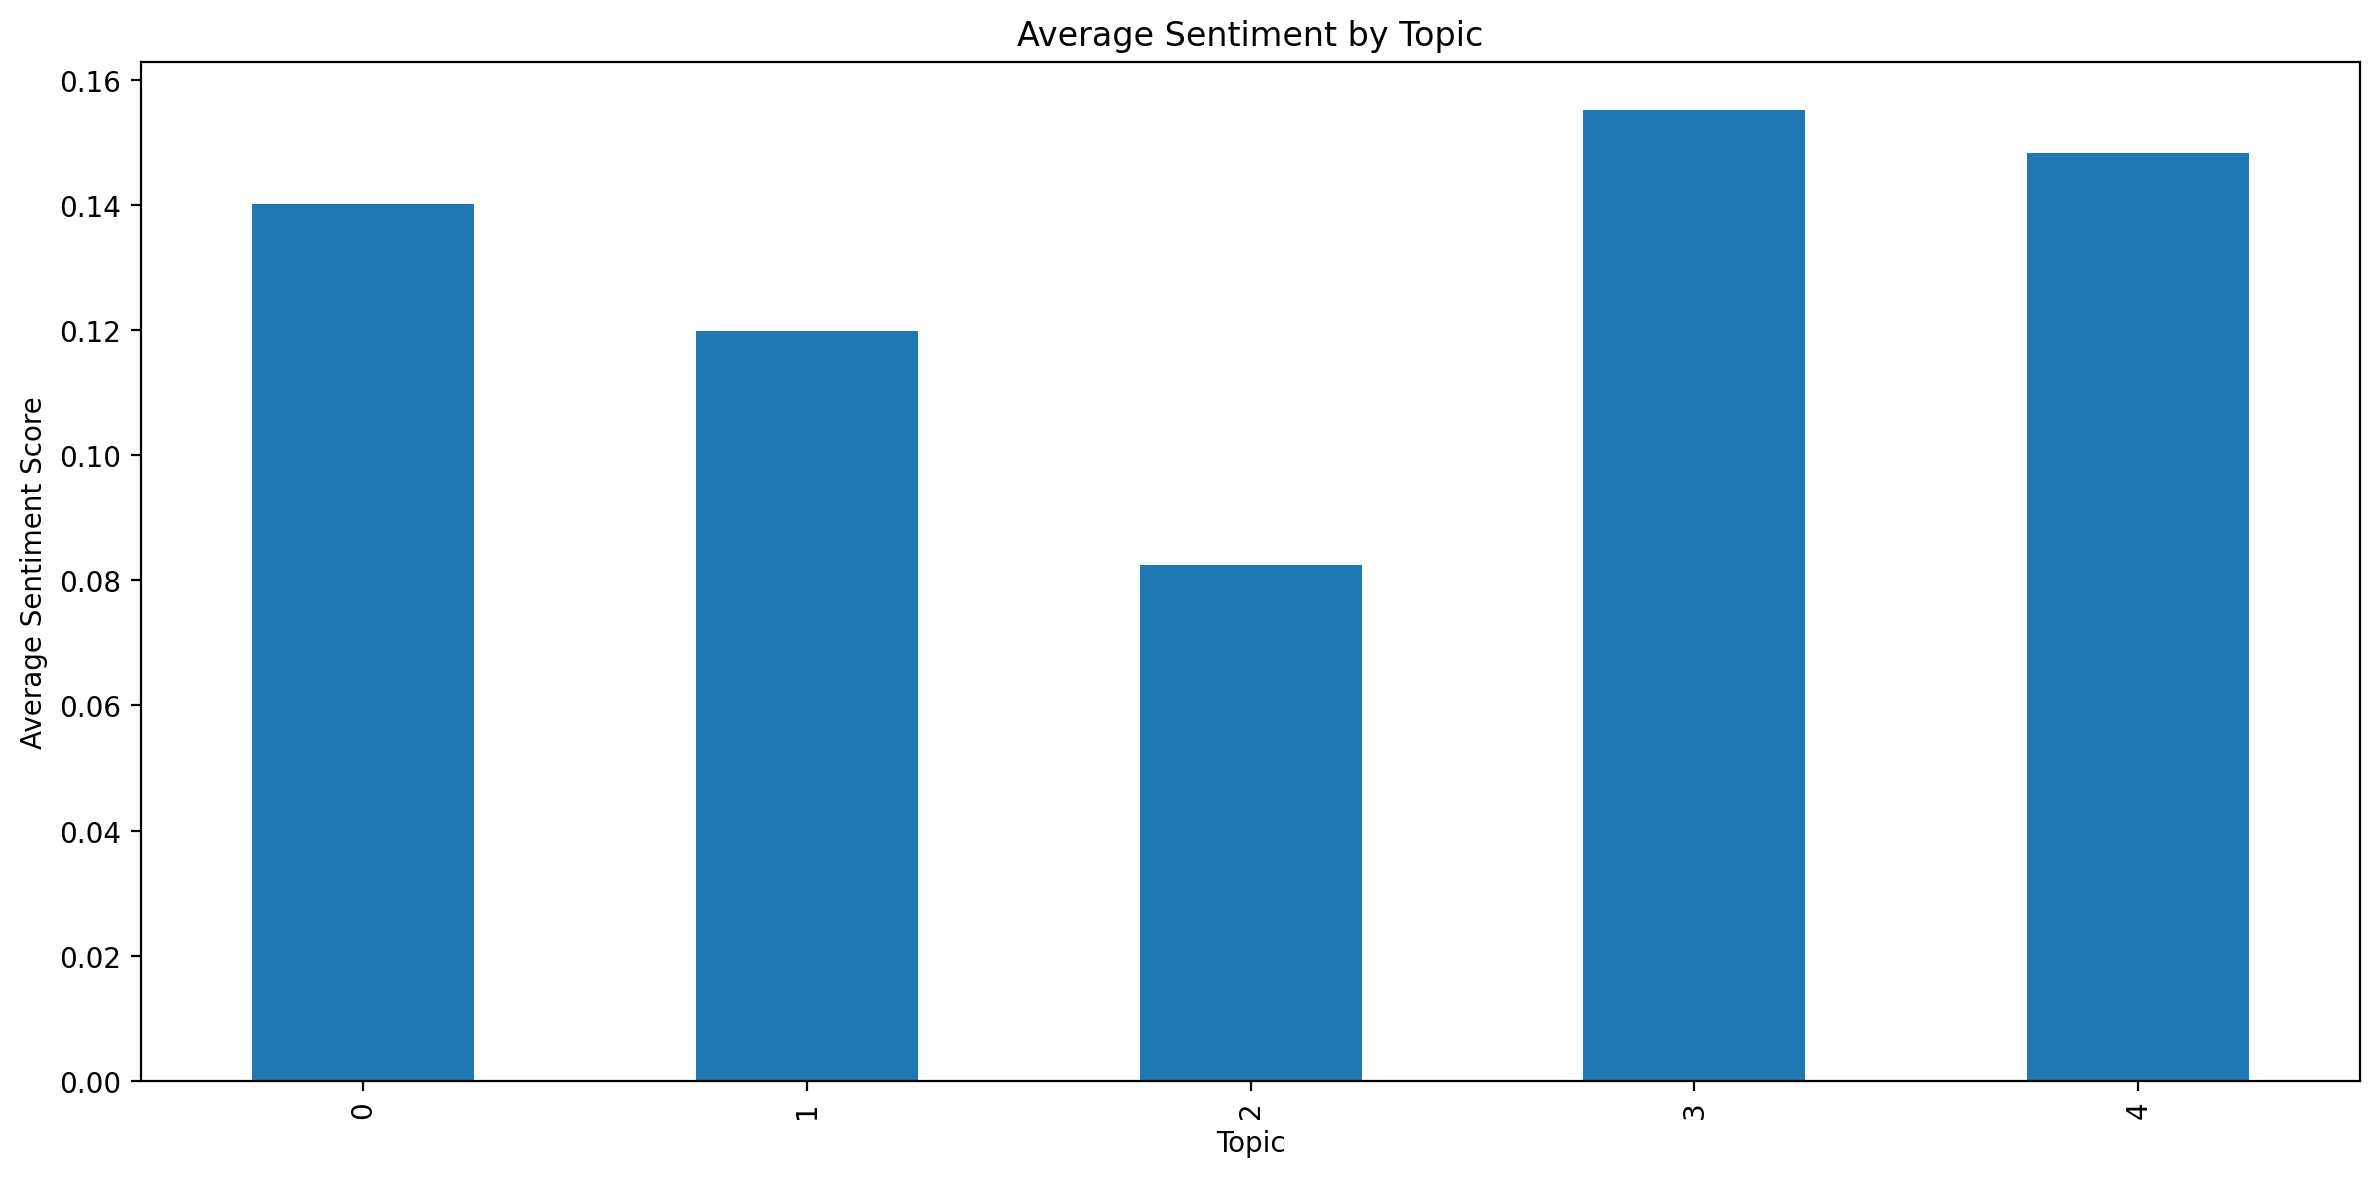

In [12]:
def get_dominant_topic(ldamodel, corpus):
    dominant_topics = []
    for bow in corpus:
        topic_probs = ldamodel.get_document_topics(bow, minimum_probability=0)
        dominant_topic = max(topic_probs, key=lambda x: x[1])[0]
        dominant_topics.append(dominant_topic)
    return dominant_topics


df["dominant_topic"] = get_dominant_topic(lda_model, corpus)

topic_sentiments = df.groupby("dominant_topic")["sentiment"].mean()

plt.figure(figsize=(12, 6))
topic_sentiments.plot(kind="bar")
plt.title("Average Sentiment by Topic")
plt.xlabel("Topic")
plt.ylabel("Average Sentiment Score")
plt.tight_layout()
plt.show()

## Word Clouds

Let's create word clouds for each topic to visually represent the most significant words.


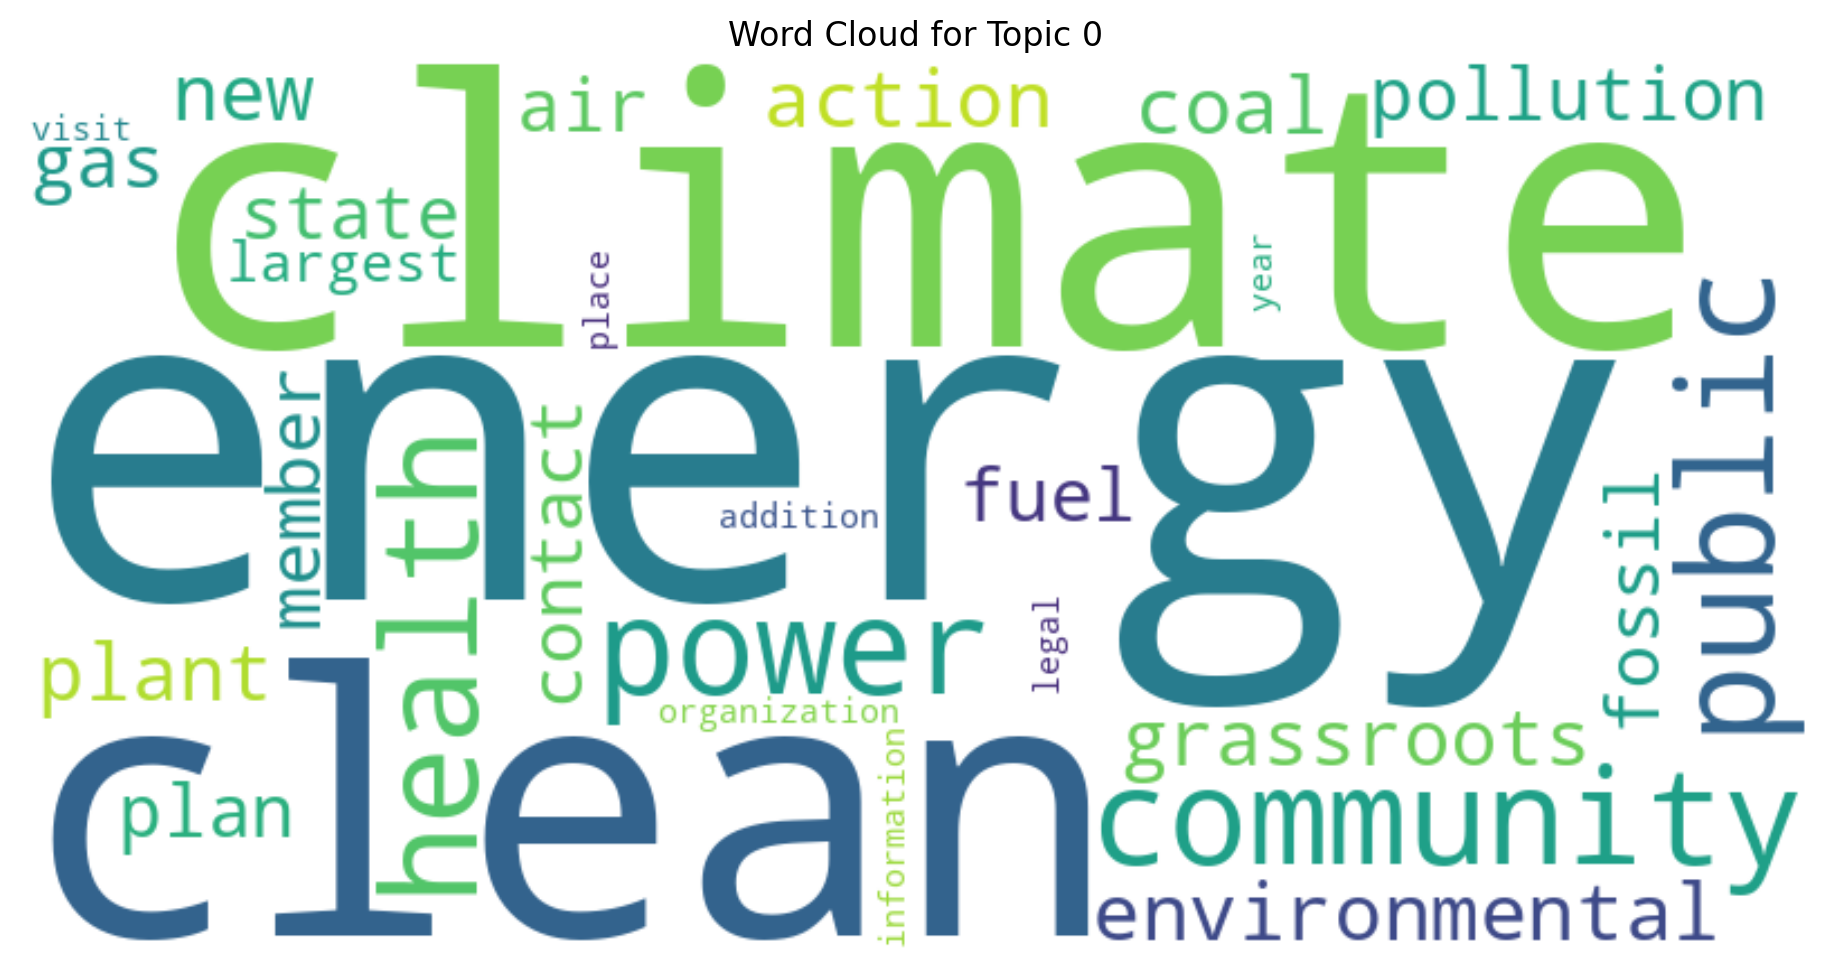

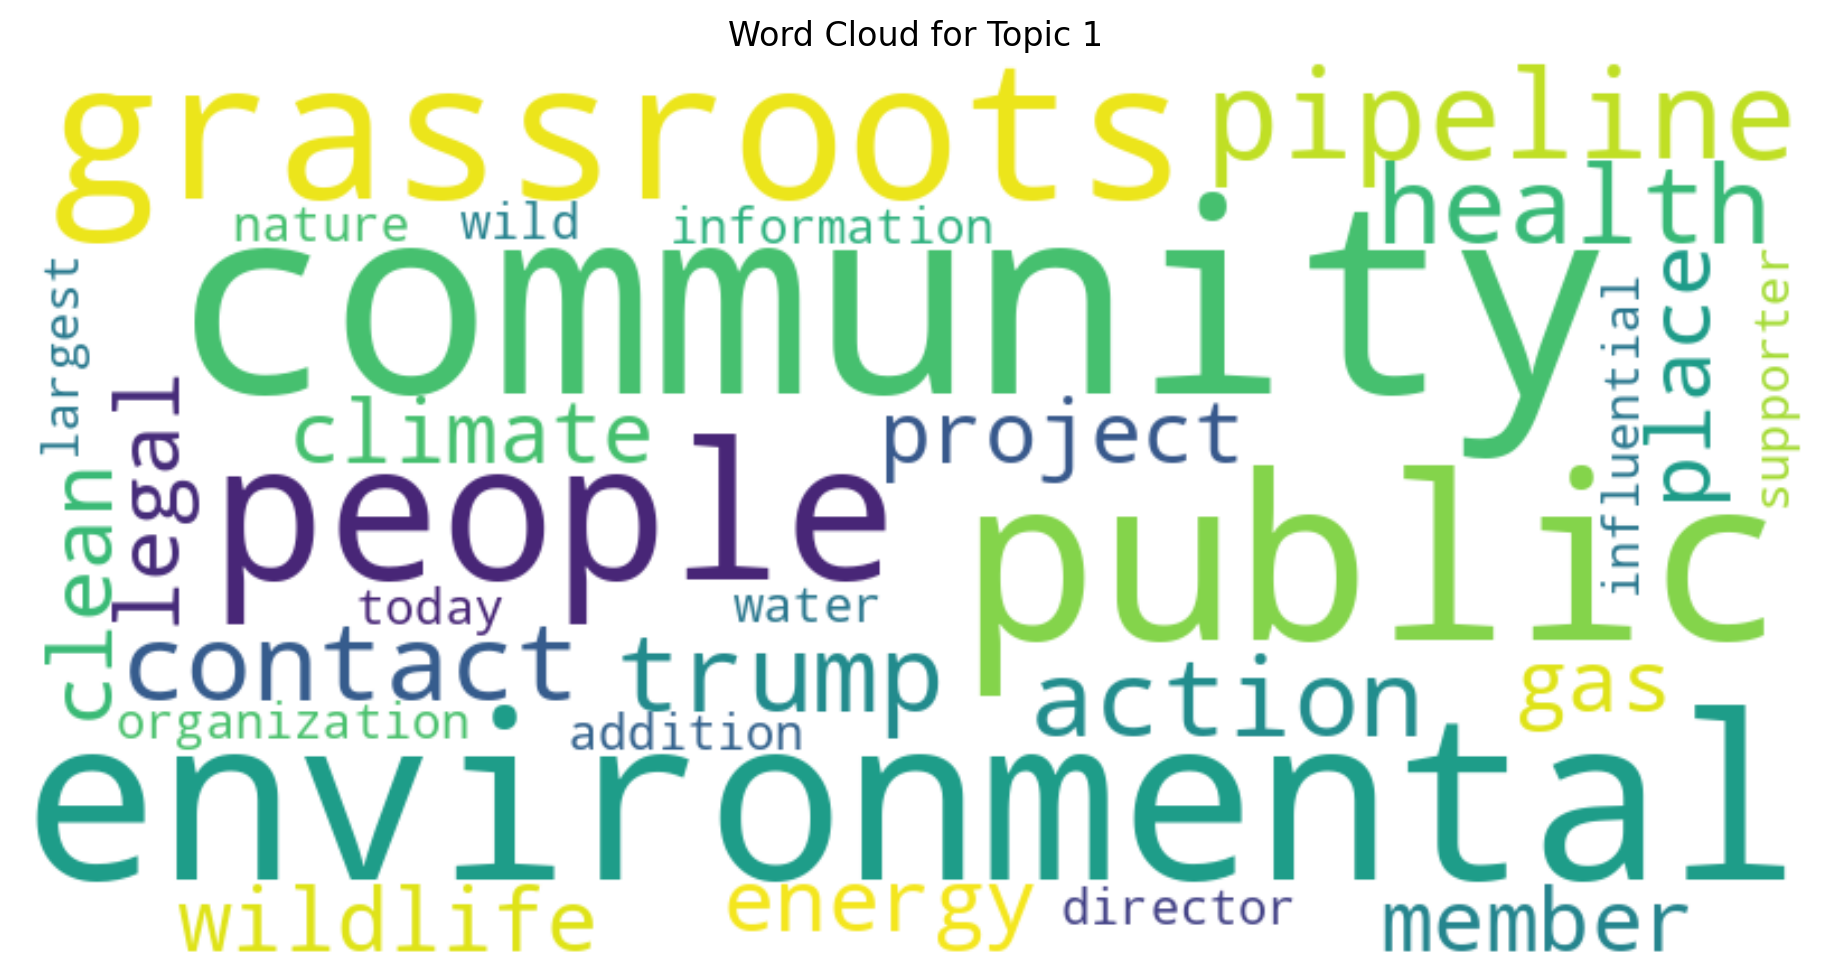

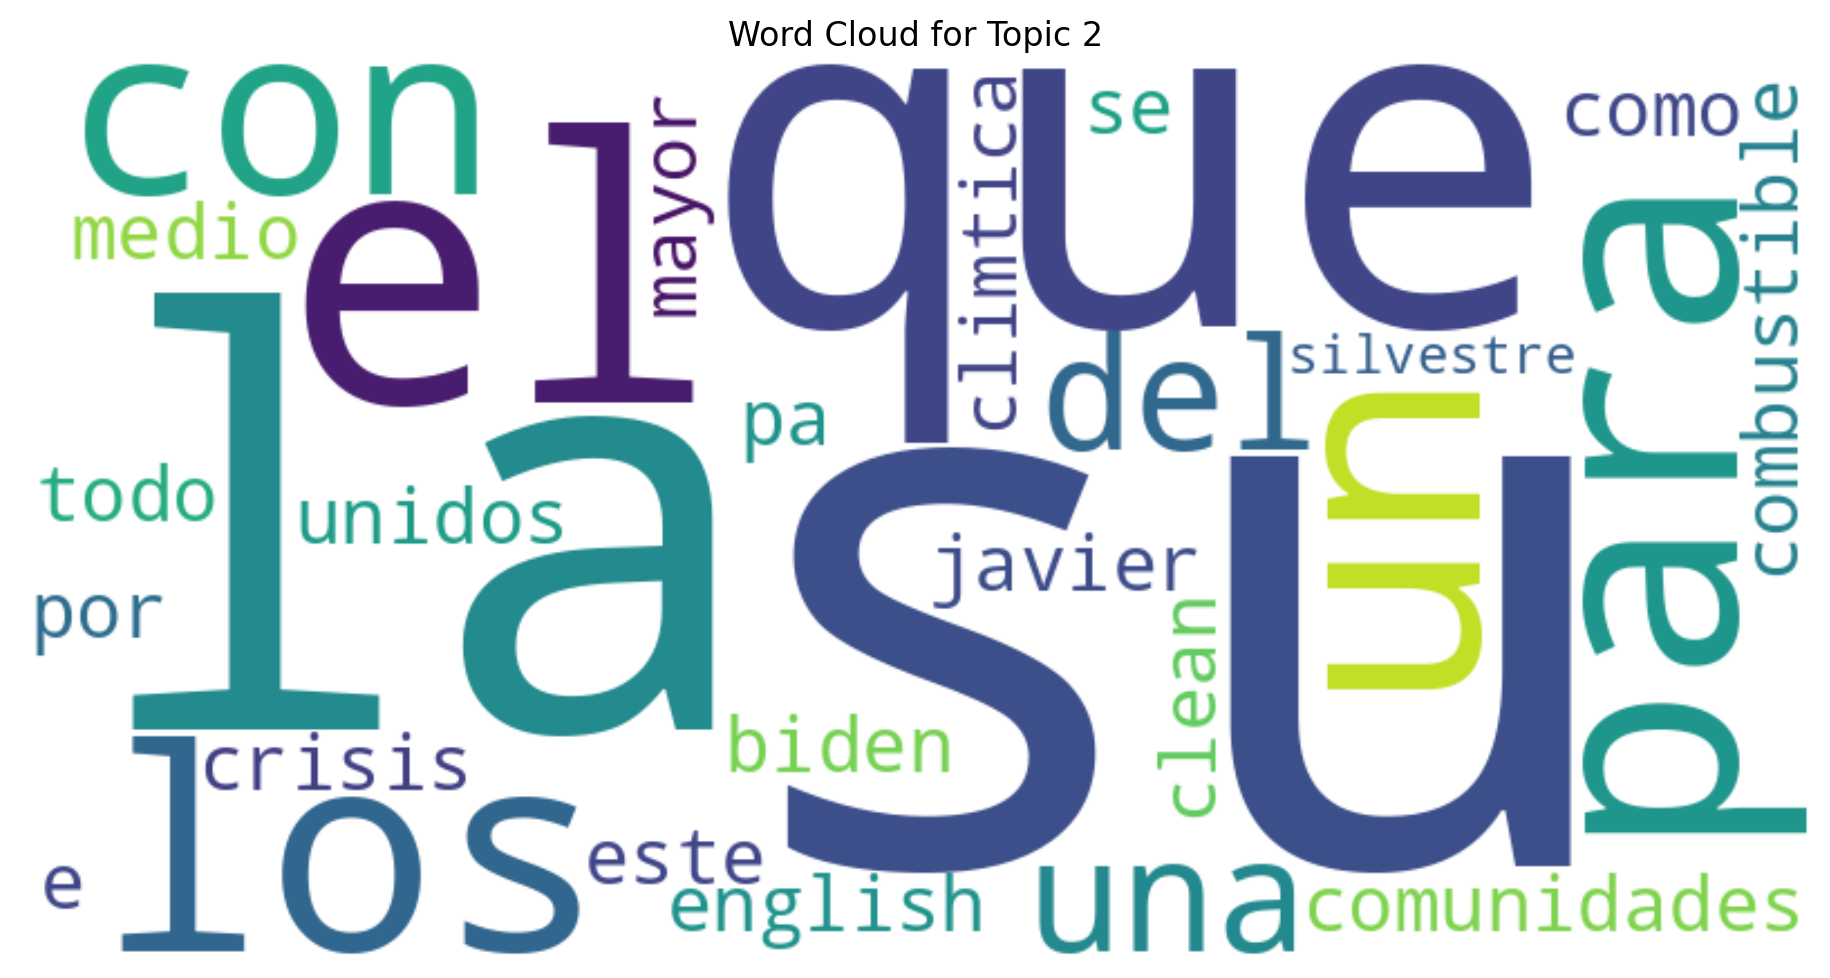

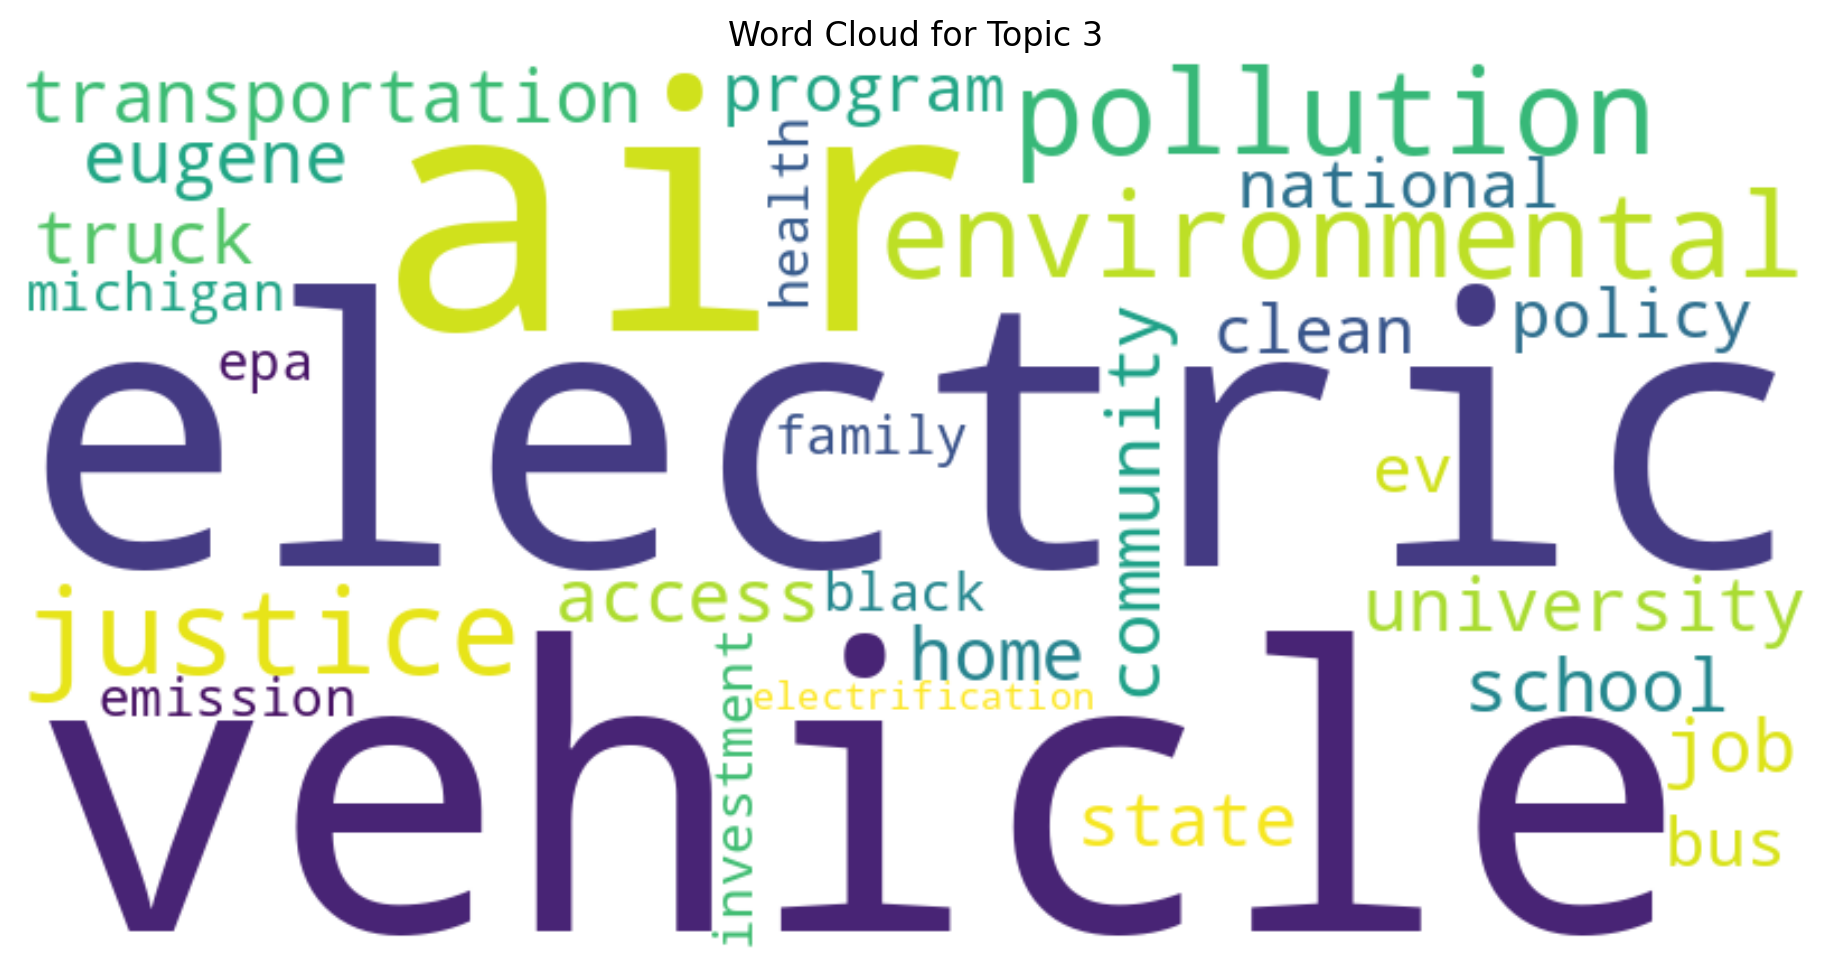

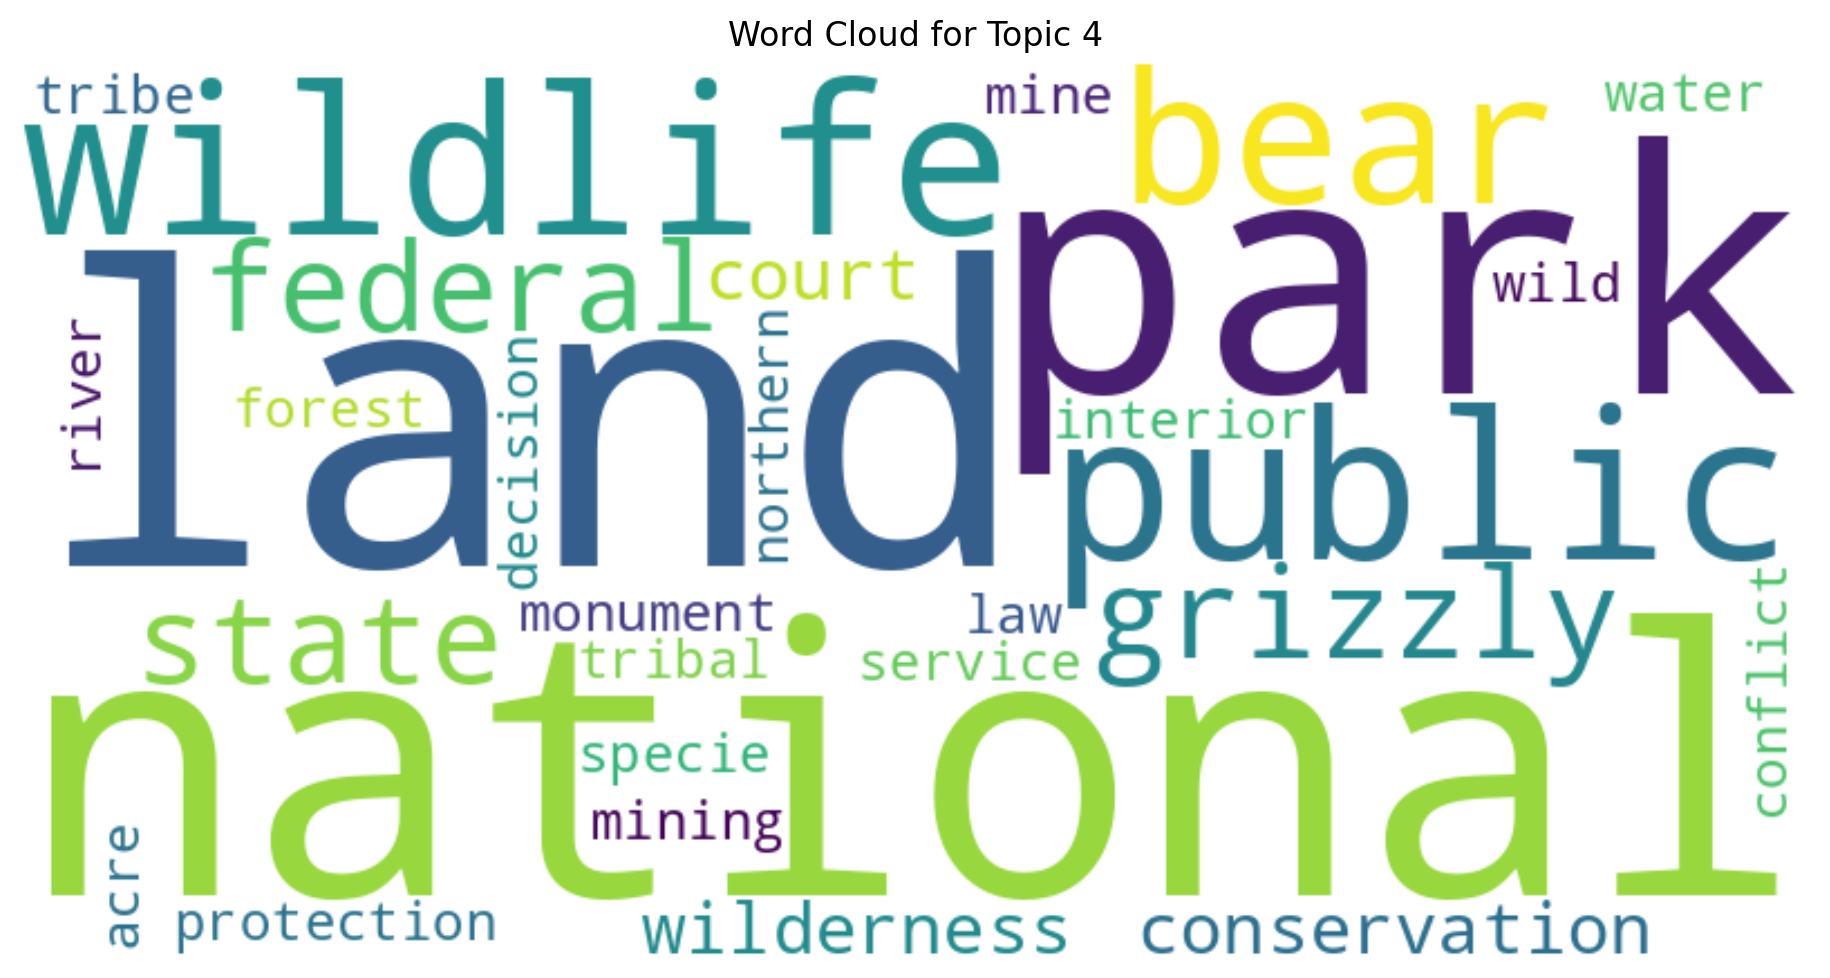

In [13]:
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
        text
    )
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.tight_layout()
    plt.show()


for topic_id in range(optimal_num_topics):
    topic_words = dict(lda_model.show_topic(topic_id, topn=30))
    generate_wordcloud(" ".join(topic_words.keys()), f"Word Cloud for Topic {topic_id}")

## Saving Results

Let's save our analysis results for future reference or further analysis.


In [14]:
output_file = h.project.workspace_dir / "data/processed/sierra_club_analysis-1.csv"
df[["content", "processed_string", "sentiment", "dominant_topic"]].to_csv(
    output_file, index=False
)
print(f"Analysis results saved to {output_file}")

Analysis results saved to /Users/yj.lee/workspace/courses/nlp4ss/workspace/data/processed/sierra_club_analysis-1.csv


## Conclusion

In this notebook, we've conducted a comprehensive NLP analysis of Sierra Club press releases. Here's a summary of what we've accomplished:

1. **Text Preprocessing**: We cleaned and normalized the text data, focusing on nouns and adjectives which are most informative for our analysis.

2. **Word Frequency Analysis**: We identified the most common words in the press releases, giving us an initial insight into the main themes.

3. **Named Entity Recognition**: We extracted key entities mentioned in the press releases, which can be useful for understanding who and what the Sierra Club frequently discusses.

4. **Sentiment Analysis**: We analyzed the overall sentiment of the press releases, which can indicate the general tone of Sierra Club's communications.

5. **TF-IDF Analysis**: We identified important terms in individual documents, which can highlight specific focus areas in different press releases.

6. **Topic Modeling**: Using LDA, we discovered the main topics discussed in the press releases. We also determined the optimal number of topics for our dataset.

7. **Topic-Sentiment Analysis**: We examined the average sentiment associated with each topic, which can reveal how different subjects are framed.

8. **Word Clouds**: We created visual representations of the most significant words in each topic.

This analysis provides valuable insights into the content and framing of Sierra Club's press releases. It can be used to understand their communication strategies, main areas of focus, and how they discuss different environmental issues.

For further analysis, you might consider:

- Examining how topics and sentiment change over time
- Comparing these results with press releases from other environmental organizations
- Diving deeper into specific topics or entities of interest

Remember that while these computational methods provide powerful insights, they should be combined with close reading and domain expertise for the most comprehensive understanding of the text data.
